In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [2]:
df= pd.read_csv("../Data/Processed/featured_dataset_V2.csv")

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   acceleration_x           1340 non-null   float64
 1   acceleration_y           1340 non-null   float64
 2   acceleration_z           1340 non-null   float64
 3   temperature_c            1340 non-null   float64
 4   humidity_percent         1340 non-null   float64
 5   wind_speed_mps           1340 non-null   float64
 6   fft_peak_freq            1340 non-null   float64
 7   fft_magnitude            1340 non-null   float64
 8   degradation_score        1340 non-null   float64
 9   structural_condition     1340 non-null   int64  
 10  damage_class             1340 non-null   object 
 11  forecast_score_next_30d  1340 non-null   float64
 12  date                     1340 non-null   object 
 13  time                     1340 non-null   object 
 14  vibration_rms           

In [3]:
def apply_log_transformation(df, features_to_transform):
    for feature in features_to_transform:
        if feature in df.columns:
            # Add a small constant to handle zero or negative values before log transformation
            df[feature] = np.log1p(df[feature] - df[feature].min() + 1e-6) # log1p(x) = log(1+x)
    return df

In [4]:
# Identify numerical features for log transformation. Exclude 'structural_condition' and 'damage_class' as they are target/categorical.
# Also exclude 'timestamp' related columns.
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
features_to_exclude_from_log = ['structural_condition', 'damage_class'] # Exclude target and related scores
features_for_log_transform = [f for f in numerical_features if f not in features_to_exclude_from_log]

# Apply log transformation
df_transformed = apply_log_transformation(df.copy(), features_for_log_transform)

In [5]:
def apply_smote(X, y):
    print(f"Original dataset shape: {X.shape}, Label distribution: {y.value_counts()}")
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"Resampled dataset shape: {X_resampled.shape}, Label distribution: {y_resampled.value_counts()}")
    return X_resampled, y_resampled

In [6]:
# Prepare data for SMOTE
# The target variable for SMOTE is 'structural_condition' or 'damage_class'. Let's use 'structural_condition'.
# Features (X) should be numerical and scaled. Target (y) should be categorical.
X = df_transformed.drop(columns=['structural_condition', 'damage_class' ,"date" ,"time"] , axis=1)
y = df_transformed['structural_condition']

#train_test_split
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , stratify=y)

 # Scale features before SMOTE, as SMOTE works better with scaled data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

    

array([[-1.29752924,  0.67744036, -0.70895886, ...,  0.5171406 ,
         0.13600571,  0.80079271],
       [ 0.48489882,  0.30954907, -0.18670274, ..., -0.48875002,
        -0.00451309,  0.075806  ],
       [-0.54632869,  0.08416368,  0.13012605, ...,  1.14576427,
        -0.28633266, -0.59035626],
       ...,
       [ 0.04500791,  0.48119119,  1.36850408, ...,  0.8376164 ,
        -0.1911796 , -0.37709839],
       [-2.26655318,  0.1122955 , -0.27715458, ...,  0.22573465,
         0.19326987, -0.3125697 ],
       [-0.07328947,  0.8657467 ,  0.81192236, ...,  0.68790905,
         0.17333559,  0.81630671]], shape=(1072, 19))

In [8]:

X_scaled_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_scaled_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Apply SMOTE
X_resampled, y_resampled = apply_smote(X_scaled_train_df, y_train)

print("log transformation and SMOTE completed.")
print("Shape of X_resampled:", X_resampled.shape)
print("Shape of y_resampled:", y_resampled.shape)

resampled_df = X_resampled.copy()
resampled_df['structural_condition'] = y_resampled

# Save the processed data (optional)

resampled_df.to_csv('../Data/Processed/V3_resampled_dataset.csv', index=False)


# Display first few rows of processed data for verification
print("\nFirst 5 rows of X_resampled:")
print(X_resampled.head())
print("\nFirst 5 rows of y_resampled:")
print(y_resampled.head())

#Display descriptive statistics of processed data
print("\nDescriptive statistics of X_resampled:")
print(X_resampled.describe())

# Display value counts of the resampled target variable
print("\nValue counts of y_resampled:")
print(y_resampled.value_counts())
  

Original dataset shape: (1072, 19), Label distribution: structural_condition
1    408
2    295
0    293
3     76
Name: count, dtype: int64
Resampled dataset shape: (1632, 19), Label distribution: structural_condition
2    408
1    408
0    408
3    408
Name: count, dtype: int64
log transformation and SMOTE completed.
Shape of X_resampled: (1632, 19)
Shape of y_resampled: (1632,)

First 5 rows of X_resampled:
   acceleration_x  acceleration_y  acceleration_z  temperature_c  \
0       -1.297529        0.677440       -0.708959       0.629305   
1        0.484899        0.309549       -0.186703       0.432250   
2       -0.546329        0.084164        0.130126       1.051677   
3        0.773057       -0.691963       -1.697533      -0.135228   
4        1.038469       -0.071286        0.068205      -0.331645   

   humidity_percent  wind_speed_mps  fft_peak_freq  fft_magnitude  \
0         -0.532465        0.272033      -1.775422       0.864803   
1          0.786016        0.633140      

In [9]:
X_test_scaled_df = pd.concat([X_scaled_test_df, y_test] , axis= 1)

X_test_scaled_df.to_csv("../Data/Processed/test_data.csv" , index=False)

In [11]:
X_scaled_train_df.columns

Index(['acceleration_x', 'acceleration_y', 'acceleration_z', 'temperature_c',
       'humidity_percent', 'wind_speed_mps', 'fft_peak_freq', 'fft_magnitude',
       'degradation_score', 'forecast_score_next_30d', 'vibration_rms',
       'vibration_peak', 'avg_temp_2h', 'avg_temp_1d', 'temp_deviation_2h',
       'wind_max_gust_2h', 'wind_avg_2h', 'wind_max_gust_1d', 'wind_avg_1d'],
      dtype='object')

In [10]:
import pickle
import joblib

joblib.dump(scaler , "../Data/Processed/scaler.pkl")

['../Data/Processed/scaler.pkl']

<Axes: >

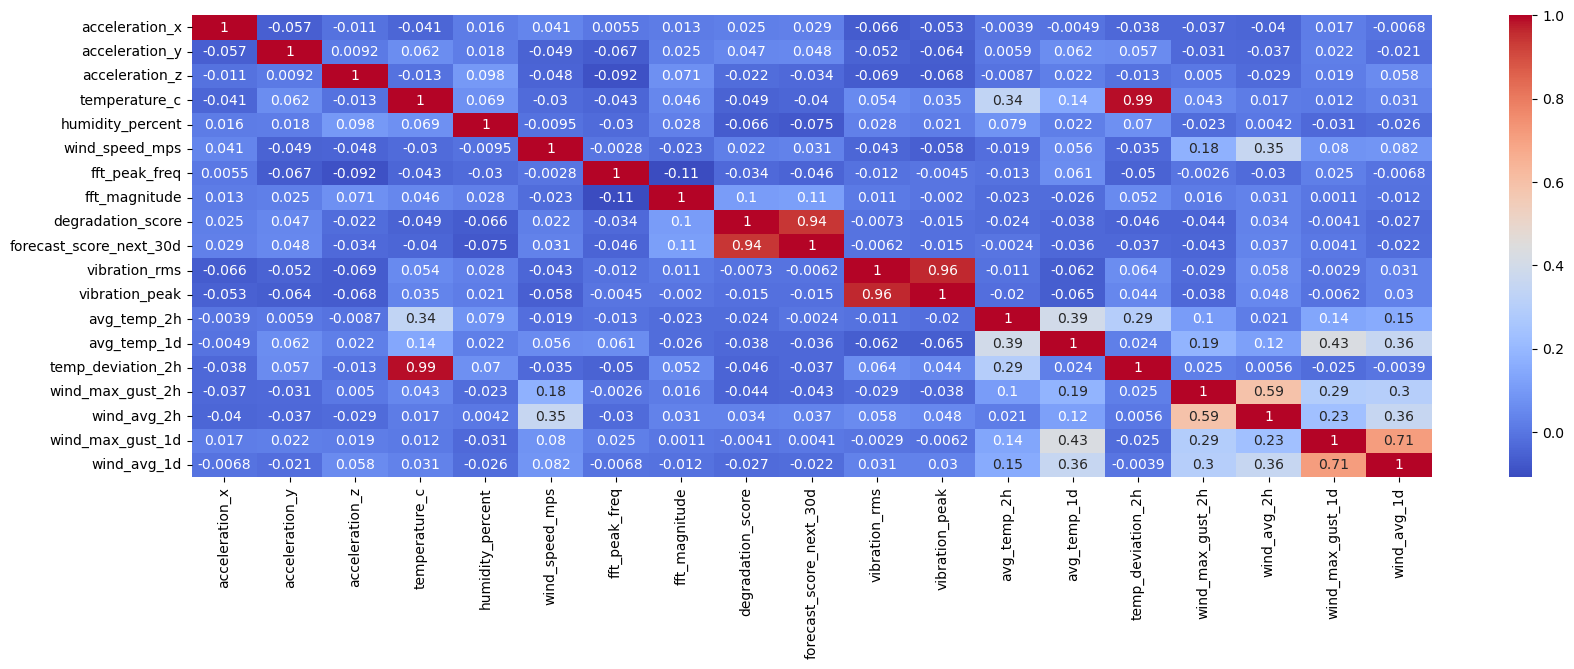

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = X_resampled.corr(numeric_only=True)
plt.figure(figsize = (20,6))
sns.heatmap(corr , annot = True , cmap = "coolwarm")

In [12]:
X_resampled.sample(10)

,acceleration_x,acceleration_y,acceleration_z,temperature_c,humidity_percent,wind_speed_mps,fft_peak_freq,fft_magnitude,degradation_score,forecast_score_next_30d,vibration_rms,vibration_peak,avg_temp_2h,avg_temp_1d,temp_deviation_2h,wind_max_gust_2h,wind_avg_2h,wind_max_gust_1d,wind_avg_1d
492,0.923992,-0.385321,0.543897,0.783411,0.044427,0.894106,0.399595,0.671097,0.720168,0.806155,-0.631593,-0.719689,0.129620,-1.072012,0.896866,0.246574,1.176451,0.189366,-0.331644
675,1.856325,0.882403,-0.507275,-0.172769,0.801973,0.323795,0.493787,-2.004311,0.761604,0.832012,1.024244,1.197770,0.124833,0.302639,-0.209683,0.137911,-0.096133,0.226144,0.716000
437,-1.116232,-1.004706,0.637841,0.807159,0.254435,1.071065,0.724447,-1.315896,-0.205907,-0.139888,0.134666,-0.387851,0.192226,-0.507516,0.869468,0.758649,1.282651,0.212172,0.917359
445,-1.283278,-1.341888,0.422909,-0.361661,0.954444,-1.758954,-1.549976,-0.491191,0.792699,0.797504,0.452942,0.114093,0.323318,-0.617958,-0.271840,0.690220,-0.896233,0.212172,0.527589
1268,0.642626,0.049796,0.177948,-0.031055,0.661940,0.007737,-0.238970,1.073933,0.644372,0.660386,-1.308603,-1.090246,-2.044500,0.044570,-0.026737,-0.894660,0.433813,0.074958,0.456219
1572,0.288306,-1.148464,1.578912,0.753269,0.539292,-1.098711,-1.954497,1.010708,1.049188,1.140155,1.107640,0.860564,0.229883,0.608263,0.697775,0.110454,0.383260,0.146676,0.251148
47,0.612273,0.400122,1.253613,0.025775,1.042738,0.878856,-0.448196,0.761199,-0.091114,-0.078203,-0.042029,0.157425,-0.019367,0.615147,-0.050491,0.279654,0.993825,0.064483,0.209559
208,0.635196,0.549616,1.200006,-0.841703,0.724370,-2.541202,-1.006948,-1.642971,0.615529,0.569407,-0.055872,0.039105,-1.030510,0.637837,-0.958900,-0.837822,-1.602383,0.170552,0.574182
1016,0.912187,1.381115,0.372236,-1.129377,1.051989,-2.234508,-0.911691,-0.311875,0.940544,0.982624,0.270600,0.276643,0.902271,0.461961,-1.225688,0.359284,0.307058,0.208180,0.265781
293,1.271078,-0.589914,-0.433965,0.758317,0.983250,-1.486805,-0.613914,-0.713839,-0.001779,-0.067469,0.010205,0.015528,0.623555,-0.229003,0.794113,-0.197554,-0.430938,0.002705,0.087694


In [13]:
y_resampled.head()

0    1
1    2
2    2
3    3
4    1
Name: structural_condition, dtype: int64

<Axes: xlabel='structural_condition', ylabel='count'>

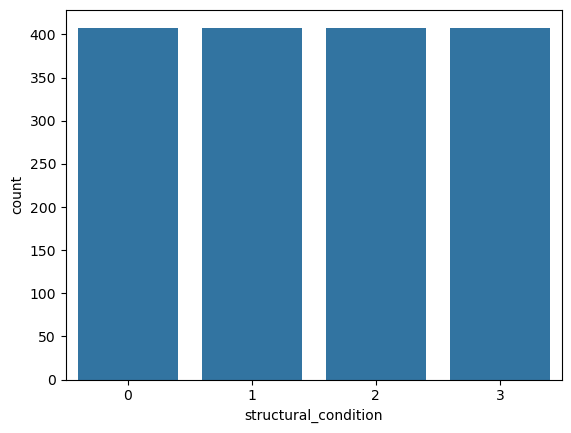

In [14]:
sns.countplot(x= y_resampled)